# Jewellery Data Set - Customer Segmentation using DBSCAN Algorithm

## Importing the required libraries

In [1]:
# ! pip install plotly
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

## Read the data set and display key statistics

In [2]:
customerDataSet = pd.read_csv("jewellery.csv")
customerDataSet.head()

,Age,Income,SpendingScore,Savings
0,58,77769,0.791329,6559.829923
1,59,81799,0.791082,5417.661426
2,62,74751,0.702657,9258.992965
3,59,74373,0.765680,7346.334504
4,87,17760,0.348778,16869.507130


In [3]:
customerDataSet.describe(include='all')

,Age,Income,SpendingScore,Savings
count,505.000000,505.000000,505.000000,505.000000
mean,59.019802,75513.291089,0.505083,11862.455867
std,24.140043,35992.922184,0.259634,4949.229253
min,17.000000,12000.000000,0.000000,0.000000
25%,34.000000,34529.000000,0.304792,6828.709702
50%,59.000000,75078.000000,0.368215,14209.932802
75%,85.000000,107100.000000,0.768279,16047.268331
max,97.000000,142000.000000,1.000000,20000.000000


In [4]:
customerDataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            505 non-null    int64  
 1   Income         505 non-null    int64  
 2   SpendingScore  505 non-null    float64
 3   Savings        505 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 15.9 KB


In [5]:
customerDataSet.isnull().sum()

Age              0
Income           0
SpendingScore    0
Savings          0
dtype: int64

-------------------------------------------------------------------------------------------------------------------
As seen in above outputs:
    
    There are 505 customer records in the dataset
    There are no null values in any of the features
    Age and Income are integer data whereas SpendingScore and Savings are float data.
    We see the min value of SpendingScore and Savings is "0" which maybe erroneous and needs verification
-------------------------------------------------------------------------------------------------------------------


## Verifying "0" values in  SpendingScore and Savings Features

In [6]:
print('\nSavings = 0:\n\n',customerDataSet[customerDataSet['Savings']==0].value_counts(),'\n')
print('---------------------------------------------------------\n')
print('SpendingScore = 0:\n\n',customerDataSet[customerDataSet['SpendingScore']==0].value_counts(),'\n')


Savings = 0:

 Age  Income  SpendingScore  Savings
17   134734  0.857922       0.0        1
dtype: int64 

---------------------------------------------------------

SpendingScore = 0:

 Age  Income  SpendingScore  Savings     
86   124372  0.0            15374.465953    1
dtype: int64 



-----------------------------------------------------------------------------------------------------------------------------
Savings = 0

    The age of this customer is 17
    Given the customer is a minor it is quite possible that he/she has 0 savings and the income/spending is from parents wealth.

SpendingScore = 0

    The age of the customer is 86
    Given the high age and other dynamics like health, needs etc. related to that age, we can assume that this customer is not spending (at least since few years) and the 0 score is justified


Hence, not dropping these records.

-----------------------------------------------------------------------------------------------------------------------------

## Exploratory Data Analysis

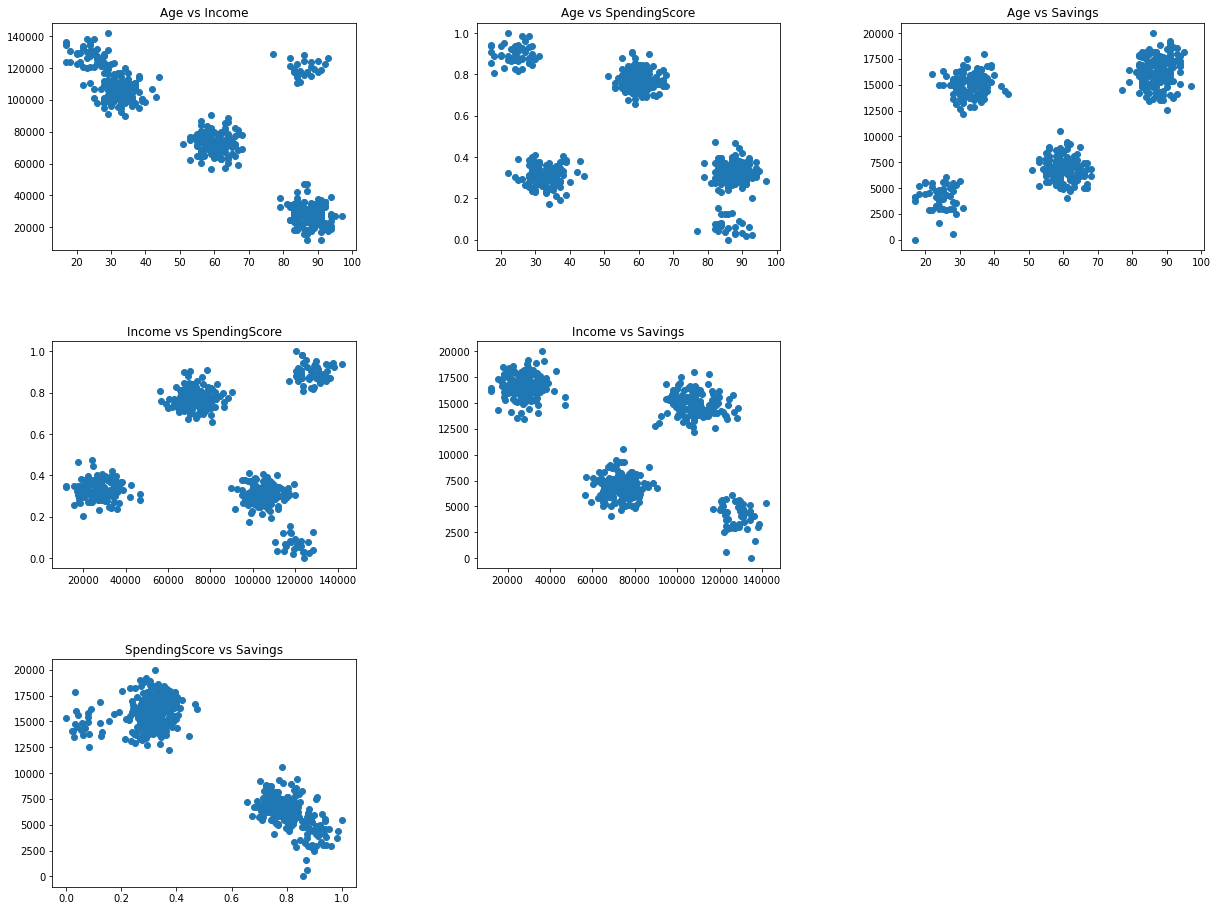

In [7]:
plt.figure(figsize=(20,15))

plt.subplot(331)
plt.scatter(customerDataSet['Age'],customerDataSet['Income'])
plt.title('Age vs Income')

plt.subplot(332)
plt.scatter(customerDataSet['Age'],customerDataSet['SpendingScore'])
plt.title('Age vs SpendingScore')

plt.subplot(333)
plt.scatter(customerDataSet['Age'],customerDataSet['Savings'])
plt.title('Age vs Savings')

plt.subplot(334)
plt.scatter(customerDataSet['Income'],customerDataSet['SpendingScore'])
plt.title('Income vs SpendingScore')

plt.subplot(335)
plt.scatter(customerDataSet['Income'],customerDataSet['Savings'])
plt.title('Income vs Savings')

plt.subplot(337)
plt.scatter(customerDataSet['SpendingScore'],customerDataSet['Savings'])
plt.title('SpendingScore vs Savings')


#plt.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

Inference from above plots:

    The general trend seen is that with increasing age, the customers spending decreases and savings increases. 
    This is also impacted by age, typically the younger generation is spending more and saving less and older ones are spending less and saving more
    There are exceptions although to the general trend as said above
    We do observe data where higher aged customers are spending more and higher income customers are saving less. These could be age and lifestyle related expenses like health, children education/marriage etc.
    
Higher the spending score, lower the savings is the trend observed. There seems to be a strong co-relation (although inverse) between these 2 features. 

Hence plotting a heatmap to check co-relation score. 

<AxesSubplot:>

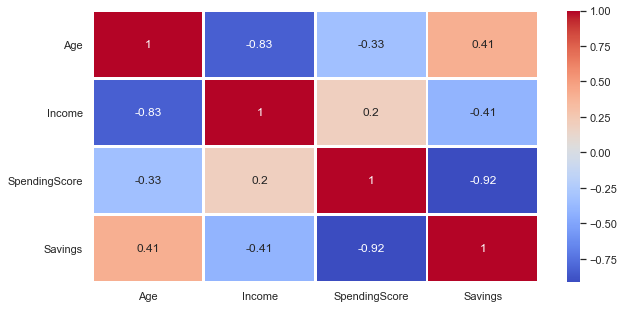

In [8]:
# for correlation
corr = customerDataSet.corr()
sns.set(rc = {'figure.figsize':(10,5)})
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=1.9)

As seen in scatter plot and the heatmap, there is certainly a high corelation between SpendingScore and Savings. They are inversely related. We can generalize here that a high spender has low savings and a low spender has high savings.

Hence dropping the Savings feature from the dataset. A spending score of the customer seems to be a better metric to use for segmentation and gathering insights from and hence Savings feature is chosen to drop

In [9]:
# Dropping the Savings feature
customerDataSet=customerDataSet.drop(labels='Savings', axis=1)

## Scaling the data

In [10]:
X = StandardScaler().fit_transform(customerDataSet)

## Deriving the minpoints and eps using heuristics

A general heuristics based apporach for minpoints is 2 times the number of features.

Using this minpoints value, we can then calculate the nearest neighbour distance and determine the eps value 

In [11]:
# Deriving Minpoints
minpoints = 2*customerDataSet.shape[1]
print ('Minpoints = ', minpoints)

Minpoints =  6


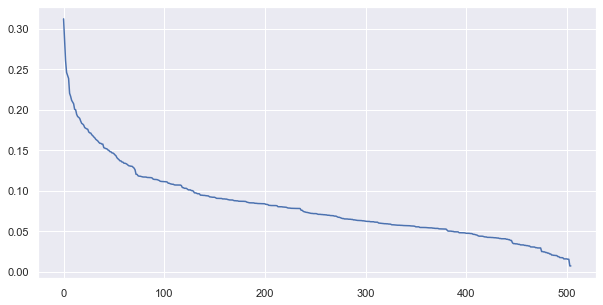

In [12]:
# Deriving eps using NearestNeighbors
neigh = NearestNeighbors(n_neighbors=minpoints)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = -np.sort(-distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

As seen in the plot above, the initial strong dip is seen at 0.2. Hence setting the eps value as 0.2 for clustering

## Clustering using DBSCAN Algorithm 

In [13]:
epsValue = 0.2
dbscan = DBSCAN(eps=epsValue,min_samples=minpoints)
y = dbscan.fit_predict(X)

## Adding the clusters to dataset and verifying number of clusters

In [14]:
customerDataSet['Cluster']=y
customerDataSet['Cluster'].unique()

array([ 0,  1,  4,  3,  2, -1], dtype=int64)

We observe that 6 clusters have been formed. 

Given that one of the clusters holds the value -1, presence of outliers can be confirmed

## Verifying Presence of Outliers and Removing Them 

In [15]:
outliers = list(dbscan.labels_).count(-1)
print('Outlier Data Points: ', outliers)

Outlier Data Points:  29


In [16]:
customerDataSet = customerDataSet[customerDataSet['Cluster']!=-1]
customerDataSet.groupby(['Cluster']).count()

,Age,Income,SpendingScore
Cluster,,,
0,154,154,154
1,141,141,141
2,120,120,120
3,19,19,19
4,42,42,42


The 29 outliers have been removed and we see the final set of 5 clusters with number of data points belonging to each cluster in the data above

## Cluster Visualization 

In [18]:
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py

Scene = dict(xaxis = dict(title  = 'Age'),yaxis = dict(title  = 'Spending Score'),zaxis = dict(title  = 'Income'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = customerDataSet['Cluster']
trace = go.Scatter3d(x=customerDataSet['Age'], y=customerDataSet['SpendingScore'], z=customerDataSet['Income'], mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 600,width = 600)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

## Clustering Summary

In [19]:
summaryData = [[0,'Blue','High (50-70)','High (0.6-0.9)','Average (50K-90K)'],[1,'Violet','Very High (79+)','Low (0-0.4)','Low (12K-50K)'],[2,'Pink','Average (25-45)','Low (0-0.4)','High (80K-120K)'],[3,'Orange','Very High (80+)','Very Low (0-0.1)','Very High (110K+)'],[4,'Yellow','Low (18-30)','Very High (0.8+)','Very High (120K+)']]
summaryDataFrame = pd.DataFrame(summaryData,columns=['Cluster #','Cluster Color', 'Age', 'Spending Score', 'Income'])
print('\nClustering Summary: ')
print('---------------------')
summaryDataFrame


Clustering Summary: 
---------------------


,Cluster #,Cluster Color,Age,Spending Score,Income
0,0,Blue,High (50-70),High (0.6-0.9),Average (50K-90K)
1,1,Violet,Very High (79+),Low (0-0.4),Low (12K-50K)
2,2,Pink,Average (25-45),Low (0-0.4),High (80K-120K)
3,3,Orange,Very High (80+),Very Low (0-0.1),Very High (110K+)
4,4,Yellow,Low (18-30),Very High (0.8+),Very High (120K+)


Clustering Insights for Jewellery Store and Indicative Business Proposals:
-------------------------------------------------------------------------------------------------


Cluster 0 (Blue): 
-----------------------
These are customers nearing retirement/recently retired. Their income and spending scores are average. These customers can be given offers on jewellery/gold that are medium to long term investment oriented, options to buy in smaller chunks and accumulate, goal oriented investment like kids marriage, education etc.


Cluster 1 (Violet): 
-------------------------
These are customers whose age is very high (super senior citizens) and their income is low. Given the age, their needs for jewellery as an ornament or investment (Gold/Silver etc.) is highly unlikely and the income also doesnt support purchase of jewellery. 
These customers can be considered for giving offers on best rates on sale of their existing jewellery or low interest rate offers on jewellery/gold loans.


Cluster 2 (Pink): 
-----------------------
These are customers in the 25-45 years age range with a decent income. However their spending score is low. Given their age they might be investing on house, funds, deposits etc. and must be having a need basis (marriage, special occassions etc.) jewellery purchase plan and hence the low spending score.
These customers can be given offers on jewellery/gold that are long term investment oriented, options to buy in smaller chunks and accumulate, goal oriented investment like kids marriage, education etc.


Cluster 3 (Orange): 
---------------------------
These are customers whose age is very high (super senior citizens) and their income is also very high. Given their high age, the high income could be a result of a steady business or good returns from investments made at an early age. Given the age and their very low spending score their seems to be no need for purchasing jewellery as an ornament. However, considering these customers are business/investment oriented, they can be considered for giving tailored offers portraying jewellery/gold as a high return investment option.


Cluster 4 (Yellow): 
--------------------------
These are young customers with very high income and very high spending score as well. Could be young entrepreneurs/customers in high paying jobs with niche skills. They have a high spending capacity and are comparitively an easier target segment here. They can be offered various offers on jewellery both as an ornament and as an investment.



